# Get started with OBP

When you prepare a quantum workload with operator backpropagation (OBP), first you must make a selection of "circuit slices", and second, you should specify a truncation threshold or "error budget" to remove terms with small coefficients in the backpropagated operator as well as set an upper bound to the overall size of the backpropagated operator. During backpropagation, the number of terms in the operator of an $N$-qubit circuit will approach $4^N$ quickly in the worst-case scenario. This guide demonstrates the steps involved in applying OBP to a quantum workload.

The main component of the `qiskit-addons-obp` package is the `backpropagate()` function. It ingests arguments for the final observable to reconstruct, a set of circuit slices to compute classically, and, optionally, a `TruncationErrorBudget` or `OperatorBudget` to provide constraints on the truncation that is done. Once these are specified, the classically computed backpropagated operator $O'$ is calculated iteratively by applying the gates from each slice, $s$, in the following way:

$$ O'^{(s)} = \mathcal{U}_{S-s+1}^\dagger O'^{(s-1)} \mathcal{U}_{S-s+1} $$

where $S$ is the total number of slices and $\mathcal{U}_{s}$ represents a single slice of the circuit. This example uses the `qiskit-addons-utils` package to prepare the circuit slices as well as generate the example circuit.


To begin, consider the time evolution of a Heisenberg XYZ chain. This Hamiltonian has the form

$$ \hat{H} = \sum_{(j,k)} \left( J_xX_jX_k + J_yY_jY_k + J_z Z_jZ_k \right) + \sum_{j} \left(h_xX_j + h_yY_j + h_zZ_j\right)$$

and the expectation value to measure will be $\langle Z_0 \rangle$.

The following code snippet generates the Hamiltonian in the form of a `SparsePauliOp` by using the `qiskit_addons_utils.problem_generators` module and a `CouplingMap`. Set the coupling constants to $J_x=\pi/8$, $J_y=\pi/4$, $J_z=\pi/2$ and external magnetic fields to $h_x=\pi/3$, $h_y=\pi/6$, $h_z=\pi/9$, and then generate a circuit that models its time evolution.

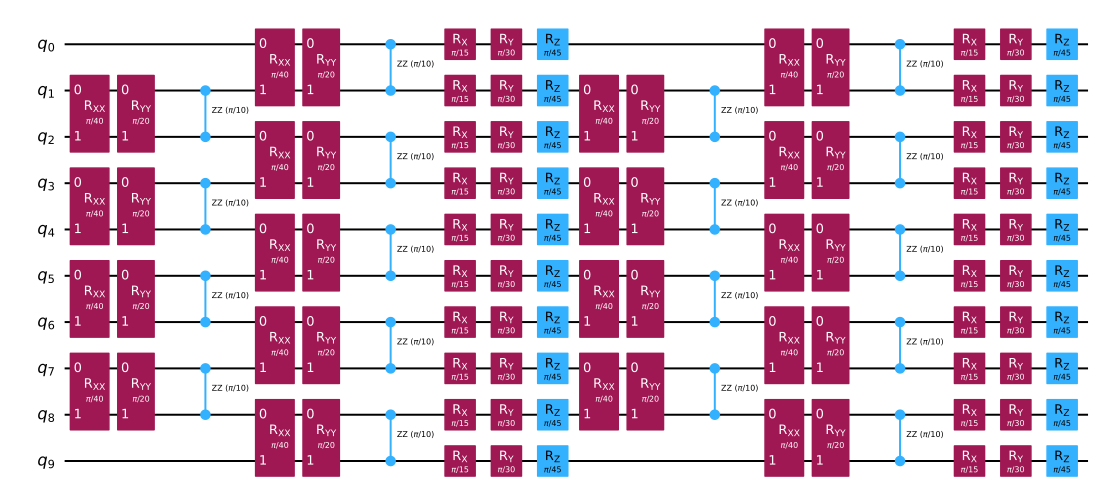

In [1]:
import numpy as np
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)

circuit.draw("mpl")

### Prepare inputs to backpropagate

Next, generate the circuit slices for backpropagation. In general, the choice of how to slice can have an impact on how well backpropagation performs for a given problem. Here, group gates of the same type into slices using the `qiskit_addons_utils.slice_by_gate_types` function.

In [2]:
slices = slice_by_gate_types(circuit)
print(f"Separated the circuit into {len(slices)} slices.")

Separated the circuit into 18 slices.


Once the slices have been generated, specify an `OperatorBudget` to provide the `backpropagate()` function with a condition to stop backpropagating the operator and prevent the classical overhead from growing further. You can also specify a truncation error budget for each slice wherein Pauli terms with small coefficients will be truncated from each slice until the error budget is filled. Any leftover budget will then be added to the following slice's budget.

Here, specify that backpropagation should stop when the number of qubit-wise commuting Pauli groups in the operator grows past $8$, and allocate an error budget of $0.005$ for each slice.

In [3]:
op_budget = OperatorBudget(max_qwc_groups=8)
truncation_error_budget = setup_budget(max_error_per_slice=0.005)

### Backpropagate slices

In this step you will define the final observable to measure and run the backpropagation across each slice. The `backpropagate()` function returns three outputs: the backpropagated observable, the remaining circuit slices that were not backpropagated (and which should be run on quantum hardware), and metadata about the backpropagation.

Note that both the `OperatorBudget` and the `TruncationErrorBudget` are optional parameters for the `backpropagate()` method. In general, the best choice for both should be heuristically chosen and requires some amount of experimentation. In this example we will backpropagate both with and without a `TruncationErrorBudget`.

<Admonition title="Note" type="note">
  By default, `backpropagate()` uses the $L_1$ norm of the truncated coefficients to bound the total error incurred from truncation, but other $L_p$ can be used if you would like to modify how the truncation error is calculated.
</Admonition>

In [4]:
# Specify a single-qubit observable
observable = SparsePauliOp("IIIIIIIIIZ")

# Backpropagate without the truncation error budget
backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    slices,
    operator_budget=op_budget,
)

# Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices, include_barriers=True)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(backpropagated_observable.paulis)} terms, which can be combined into "
    f"{len(backpropagated_observable.group_commuting(qubit_wise=True))} groups.\n"
    f"After truncation, the error in our observable is bounded by {metadata.accumulated_error(0):.3e}"
)
print(
    f"Note that backpropagating one more slice would result in {metadata.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata.backpropagation_history[-1].num_qwc_groups} groups."
)

Backpropagated 7 slices.
New observable has 18 terms, which can be combined into 8 groups.
After truncation, the error in our observable is bounded by 0.000e+00
Note that backpropagating one more slice would result in 27 terms across 12 groups.


The remaining circuit after backpropagation without truncation looks as follows:


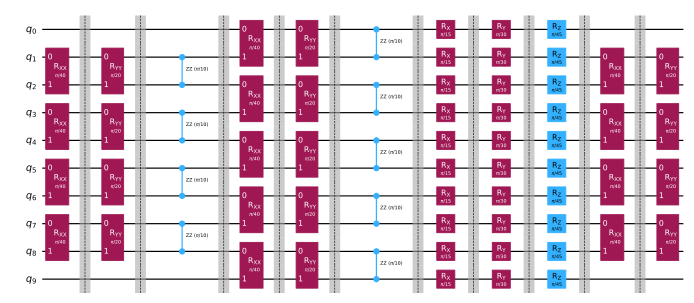

In [5]:
print(
    "The remaining circuit after backpropagation without truncation looks as follows:"
)
bp_circuit.draw("mpl", scale=0.6)

The below code snippets backpropagates the circuit *with* a truncation error budget.

In [6]:
# Backpropagate *with* the truncation error budget
backpropagated_observable_trunc, remaining_slices_trunc, metadata_trunc = (
    backpropagate(
        observable,
        slices,
        operator_budget=op_budget,
        truncation_error_budget=truncation_error_budget,
    )
)

# Recombine the slices remaining after backpropagation
bp_circuit_trunc = combine_slices(
    remaining_slices_trunc, include_barriers=True
)

print(f"Backpropagated {metadata_trunc.num_backpropagated_slices} slices.")
print(
    f"New observable has {len(backpropagated_observable_trunc.paulis)} terms, which can be combined into "
    f"{len(backpropagated_observable_trunc.group_commuting(qubit_wise=True))} groups.\n"
    f"After truncation, the error in our observable is bounded by {metadata_trunc.accumulated_error(0):.3e}"
)
print(
    f"Note that backpropagating one more slice would result in {metadata_trunc.backpropagation_history[-1].num_paulis[0]} terms "
    f"across {metadata_trunc.backpropagation_history[-1].num_qwc_groups} groups."
)

Backpropagated 10 slices.
New observable has 19 terms, which can be combined into 8 groups.
After truncation, the error in our observable is bounded by 4.933e-02
Note that backpropagating one more slice would result in 27 terms across 13 groups.


The remaining circuit after backpropagation with truncation looks as follows:


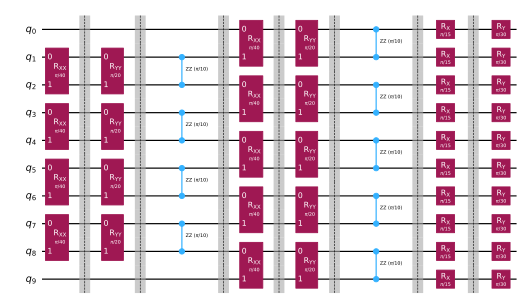

In [7]:
print(
    "The remaining circuit after backpropagation with truncation looks as follows:"
)
bp_circuit_trunc.draw("mpl", scale=0.6)

### Transpile and execute quantum workload

Now that you have backpropagated the operator, you can execute the remaining portion of the circuit on a QPU. The quantum workload, using the Estimator, should include the `bp_circuit_trunc` circuit and must measure the backpropagated operator `backpropagated_observable`

To demonstrate the effectiveness of OBP on its own, the following code snippet transpiles both the original and backpropagated circuit (with and without truncation) and simulates the circuits classically using the `StatevectorEstimator`.

In [8]:
# Specify a backend and a pass manager for transpilation
backend = FakeMelbourneV2()
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)


pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# Transpile original experiment
circuit_isa = pm.run(circuit)
observable_isa = observable.apply_layout(circuit_isa.layout)

# Transpile backpropagated experiment without truncation
bp_circuit_isa = pm.run(bp_circuit)
bp_obs_isa = backpropagated_observable.apply_layout(bp_circuit_isa.layout)

# Transpile the backpropagated experiment with truncated observable terms
bp_circuit_trunc_isa = pm.run(bp_circuit_trunc)
bp_obs_trunc_isa = backpropagated_observable_trunc.apply_layout(
    bp_circuit_trunc_isa.layout
)


estimator = StatevectorEstimator()

# Run the experiments using the exact statevector estimator
result_exact = (
    estimator.run([(circuit, observable)]).result()[0].data.evs.item()
)

result_bp = (
    estimator.run([(bp_circuit_isa, bp_obs_isa)]).result()[0].data.evs.item()
)
result_bp_trunc = (
    estimator.run([(bp_circuit_trunc_isa, bp_obs_trunc_isa)])
    .result()[0]
    .data.evs.item()
)

print(f"Exact expectation value: {result_exact}")
print(f"Backpropagated expectation value without truncation: {result_bp}")
print(f"Backpropagated expectation value with truncation: {result_bp_trunc}")
print(
    f"    - Expected Error for truncated observable: {metadata_trunc.accumulated_error(0):.3e}"
)
print(
    f"    - Observed Error for truncated observable: {abs(result_exact - result_bp_trunc):.3e}"
)

Exact expectation value: 0.8854160687717517
Backpropagated expectation value without truncation: 0.885416068771756
Backpropagated expectation value with truncation: 0.8850236647156069
    - Expected Error for truncated observable: 4.933e-02
    - Observed Error for truncated observable: 3.924e-04


Lastly the following code snippet will transpile and execute the backpropagated circuit on a QPU (both with and without truncation).

In [9]:
# Specify a backend and a pass manager for transpilation
service = QiskitRuntimeService()
backend = service.least_busy()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# Transpile backpropagated experiment without truncation
bp_circuit_isa = pm.run(bp_circuit)
bp_obs_isa = backpropagated_observable.apply_layout(bp_circuit_isa.layout)

# Transpile the backpropagated experiment with truncated observable terms
bp_circuit_trunc_isa = pm.run(bp_circuit_trunc)
bp_obs_trunc_isa = backpropagated_observable_trunc.apply_layout(
    bp_circuit_trunc_isa.layout
)

# Run the experiments using Estimator primitive
estimator = EstimatorV2(mode=backend)

result_bp_qpu = (
    estimator.run([(bp_circuit_isa, bp_obs_isa)]).result()[0].data.evs.item()
)

result_bp_trunc_qpu = (
    estimator.run([(bp_circuit_trunc_isa, bp_obs_trunc_isa)])
    .result()[0]
    .data.evs.item()
)

print(f"Exact expectation value: {result_exact}")
print(f"Backpropagated expectation value without truncation: {result_bp_qpu}")
print(
    f"Backpropagated expectation value with truncation: {result_bp_trunc_qpu}"
)
print(
    f"    - Observed Error for observable without truncation: {abs(result_exact - result_bp_qpu):.3e}"
)
print(
    f"    - Observed Error for truncated observable: {abs(result_exact - result_bp_trunc_qpu):.3e}"
)

Exact expectation value: 0.8854160687717517
Backpropagated expectation value without truncation: 0.8607281593588844
Backpropagated expectation value with truncation: 0.8393389416453781
    - Observed Error for observable without truncation: 2.469e-02
    - Observed Error for truncated observable: 4.608e-02


## Next steps

<Admonition type="tip" title="Recommendations">
    - Read through the [OBP tutorial](https://learning.quantum.ibm.com/tutorial/improving-estimation-of-expectation-values-with-operator-backpropagation) on the IBM Quantum Learning Platform.
</Admonition>